<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Rio_Dengue_Risk_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.lib.stride_tricks import sliding_window_view

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [40]:
def get_data(ibge, ey_start, ey_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = ibge
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = ey_start
  ey_end = ey_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])
  dados = pd.read_csv(url_resp, index_col='SE')
  return dados

In [41]:
rio_neighbours = [3302007,3305554, 3303500,3302858,3303203,3305109,3300456,3301702]

In [42]:
rio = get_data(ibge = 3304557, ey_start = 2010, ey_end = 2023)
sp = get_data(ibge = 3550308, ey_start = 2010, ey_end = 2023)
br = get_data(ibge = 5300108, ey_start = 2010, ey_end = 2023)

In [48]:
rio_neighbours = [3304557, 3302007,3305554, 3303500,3301702, 3305109, 3300456, 3303203, 3302858, 3304144, 3302270, 3302858]

In [55]:
r_nb = pd.DataFrame()
for i, ibge in enumerate(rio_neighbours):
    data = get_data(ibge=ibge, ey_start=2010, ey_end=2023)
    data['region'] = f"r{i+1}"
    pd.concat([r_nb, data])

In [53]:
len(r_nb)

11

## Data Exploration

Because I want to learn how to predict the nivel, and the source uses
1. Weather
2. Twitter
3. Reported Cases

In [45]:
rio['region'] = 'rio'
sp['region'] = 'sao_paulo'
br['region'] = 'brasilia'
all = pd.concat([rio, sp, br])

In [46]:
all2 = pd.concat([rio, r1, r2, r3, r4])

In [47]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [10]:
all.head(5)

data_iniSE  casos_est  casos_est_min  casos_est_max  casos     p_rt1  \
SE                                                                             
202352  2023-12-24     1198.0           1198         1198.0   1198  0.268316   
202351  2023-12-17     1098.0           1098         1098.0   1098  0.145074   
202350  2023-12-10     1411.0           1411         1411.0   1411  1.000000   
202349  2023-12-03     1149.0           1149         1149.0   1149  1.000000   
202348  2023-11-26      983.0            983          983.0    983  1.000000   

        p_inc100k  Localidade_id  nivel                  id  ...    umidmin  \
SE                                                           ...              
202352  18.080702              0      4  330455720235220087  ...  53.996714   
202351  16.571460              0      4  330455720235120080  ...  53.591186   
202350  21.295383              0      4  330455720235020074  ...  57.914057   
202349  17.341173              0      4  330455720234920067  ...  62.861486   
202348  14.835835              0      4  330455720234820060  ...  61.887029   

          tempmed    tempmax  casprov  casprov_est  casprov_est_min  \
SE                                                                    
202352  27.067986  30.961400    994.0          NaN              NaN   
202351  26.296557  30.698757    922.0          NaN              NaN   
202350  24.894814  28.931171    974.0          NaN              NaN   
202349  27.107300  30.804943    726.0          NaN              NaN   
202348  25.268314  28.938500    570.0          NaN              NaN   

        casprov_est_max  casconf  notif_accum_year  region  
SE                                                          
202352              NaN      NaN            496579     rio  
202351              NaN      NaN            496579     rio  
202350              NaN      NaN            496579     rio  
202349              NaN      NaN            496579     rio  
202348              NaN      NaN            496579     rio  

[5 rows x 30 columns]

In [11]:
cols = ['data_iniSE', 'nivel','p_inc100k', 'tweet', 'Rt', 'p_rt1', 'tempmin', 'umidmax', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'region']
all_filt = all[cols].copy()
all2_filt = all2[cols].copy()

In [12]:
all_filt.isna().sum()

data_iniSE     0
nivel          0
p_inc100k      0
tweet         81
Rt             0
p_rt1          0
tempmin        0
umidmax       26
umidmed       44
umidmin       44
tempmed       44
tempmax       44
region         0
dtype: int64

In [13]:
all2_filt.isna().sum()

data_iniSE      0
nivel           0
p_inc100k       0
tweet         135
Rt              0
p_rt1           0
tempmin         0
umidmax       111
umidmed       111
umidmin       111
tempmed       111
tempmax       111
region          0
dtype: int64

In [14]:
def plot_ts(df, cols, date_col="data_iniSE", region_col="region", na_fill=0):

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    df[cols] = df[cols].fillna(na_fill)

    regions = df[region_col].unique()

    for col in cols:
        plt.figure(figsize=(17, 5))
        for r in regions:
            g = df[df[region_col] == r].sort_values(date_col)
            plt.plot(g[date_col], g[col], marker='o', markersize=2, label=f"Region {r}")
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


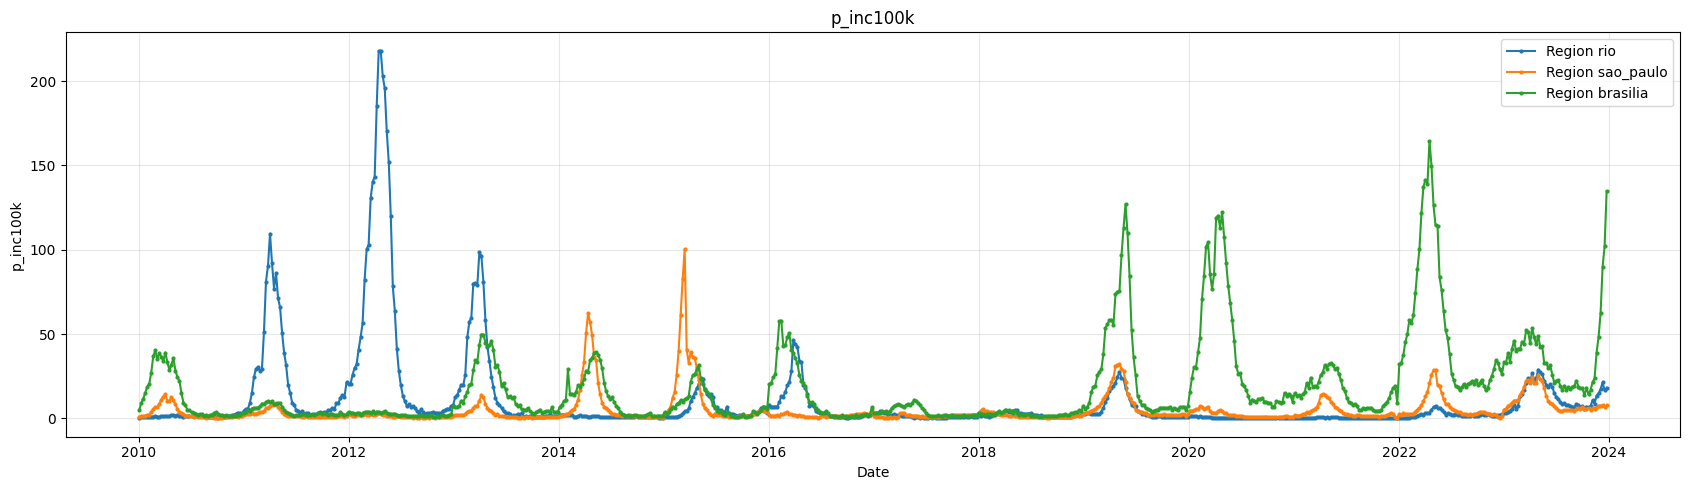

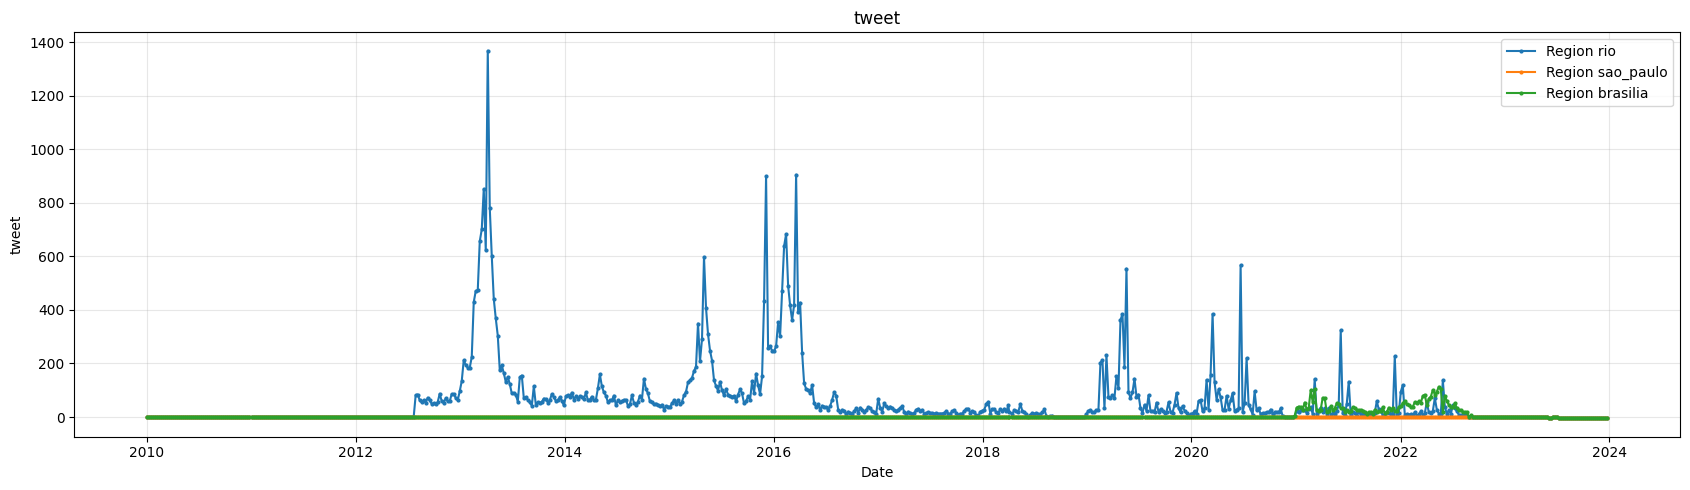

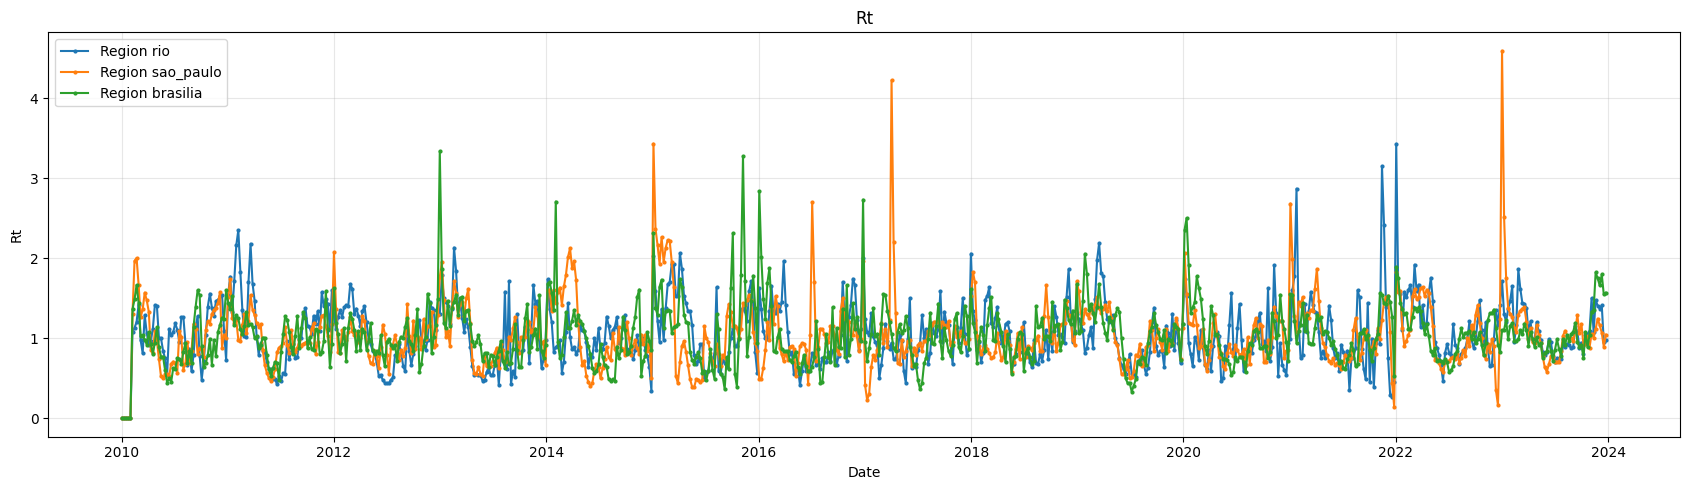

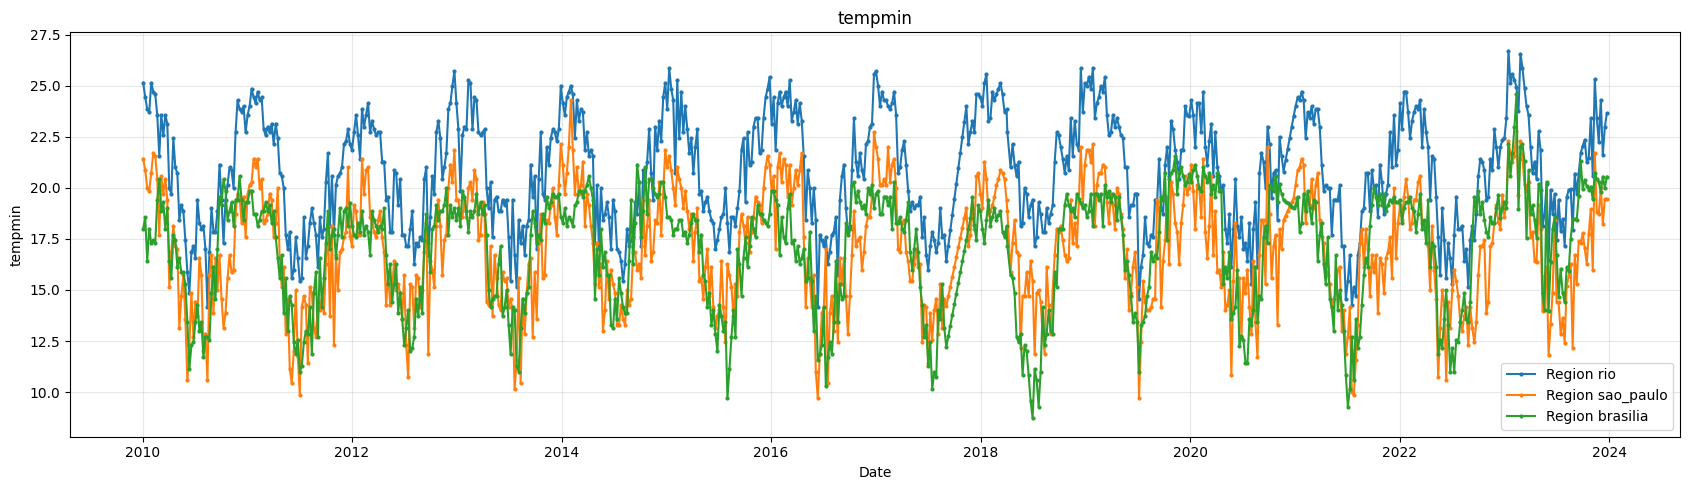

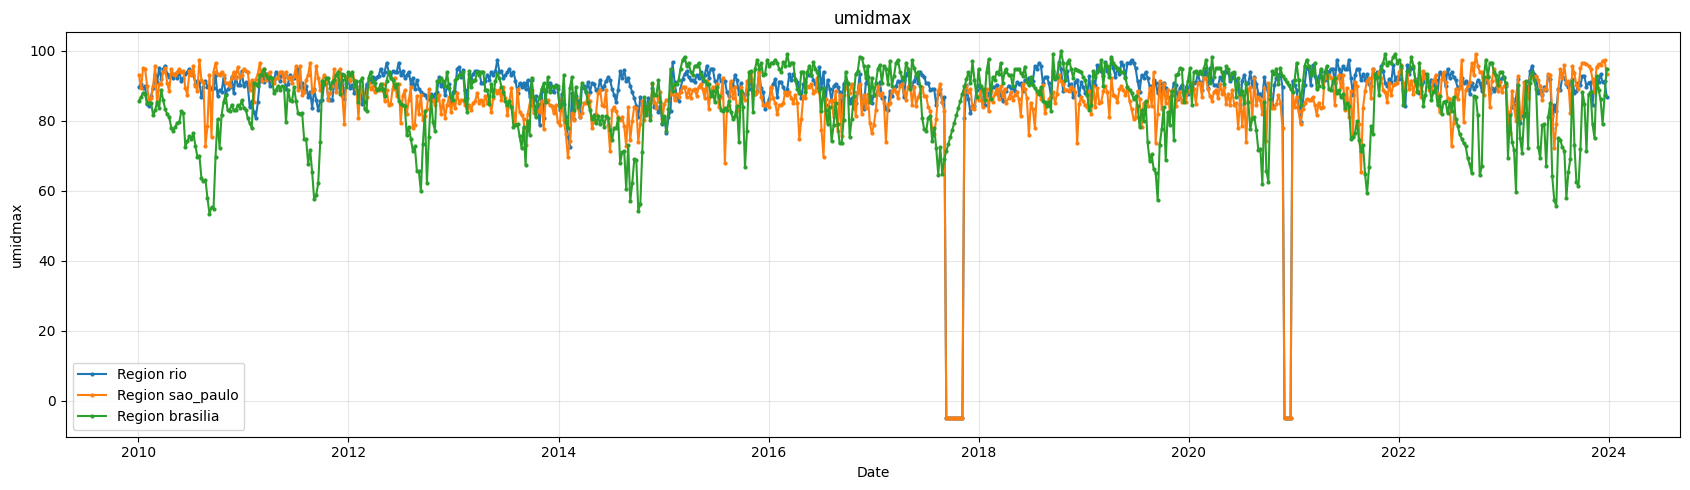

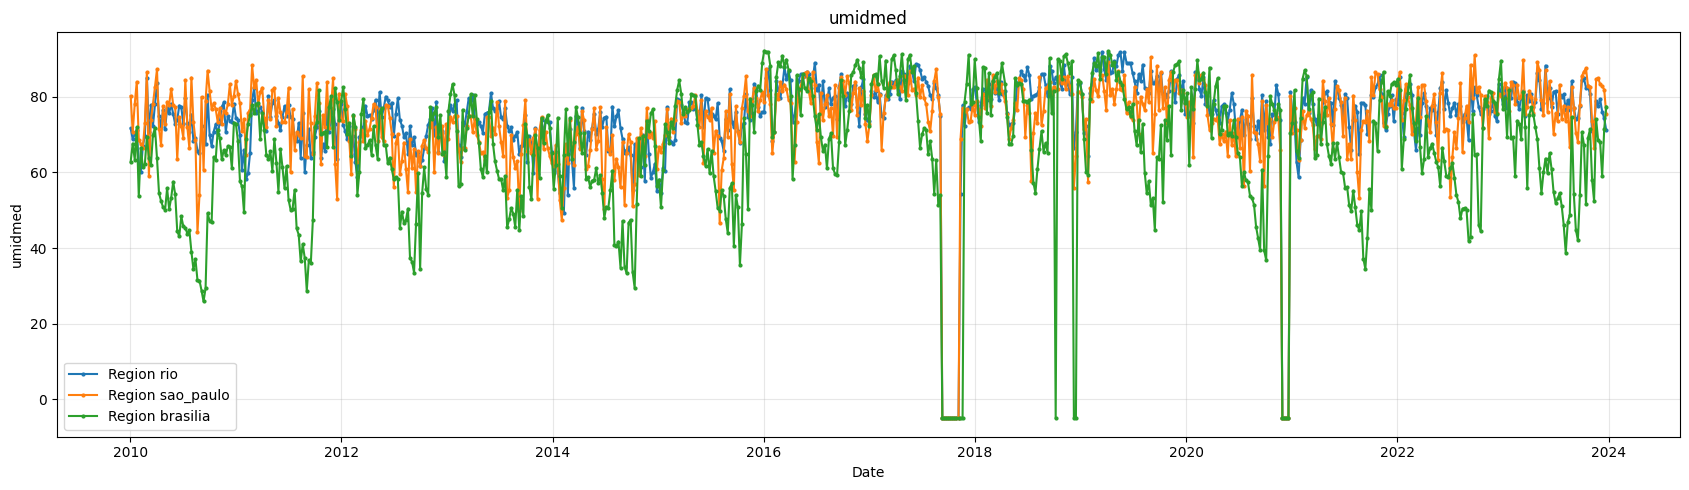

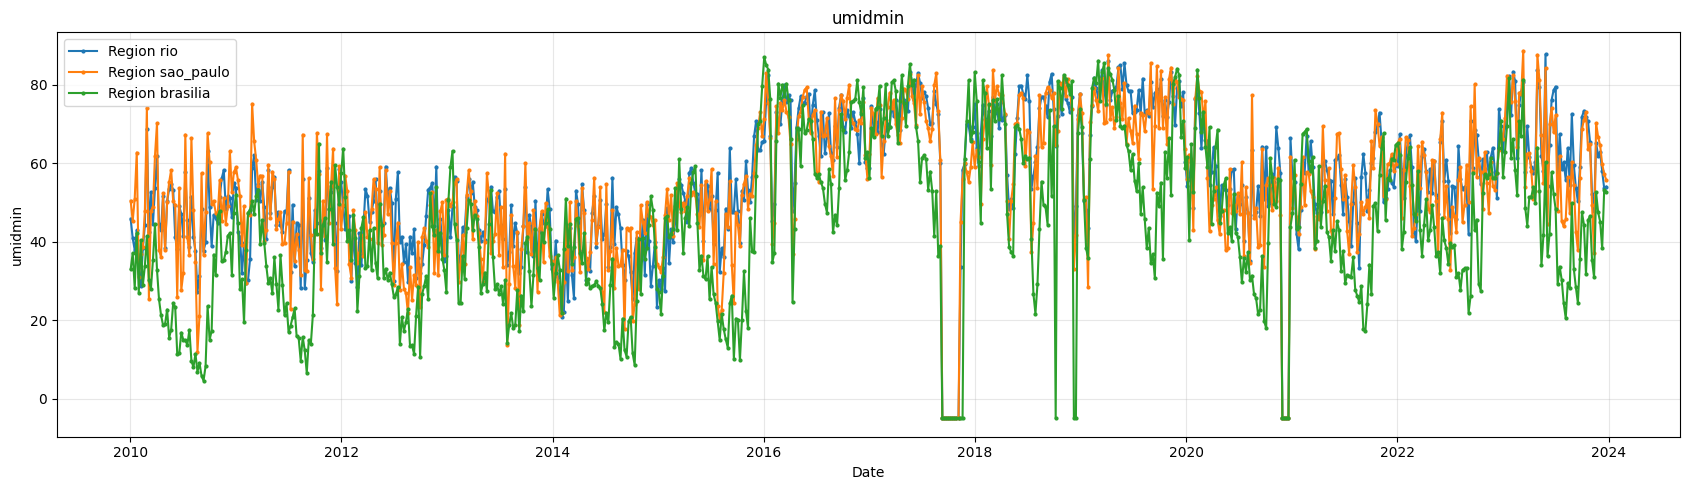

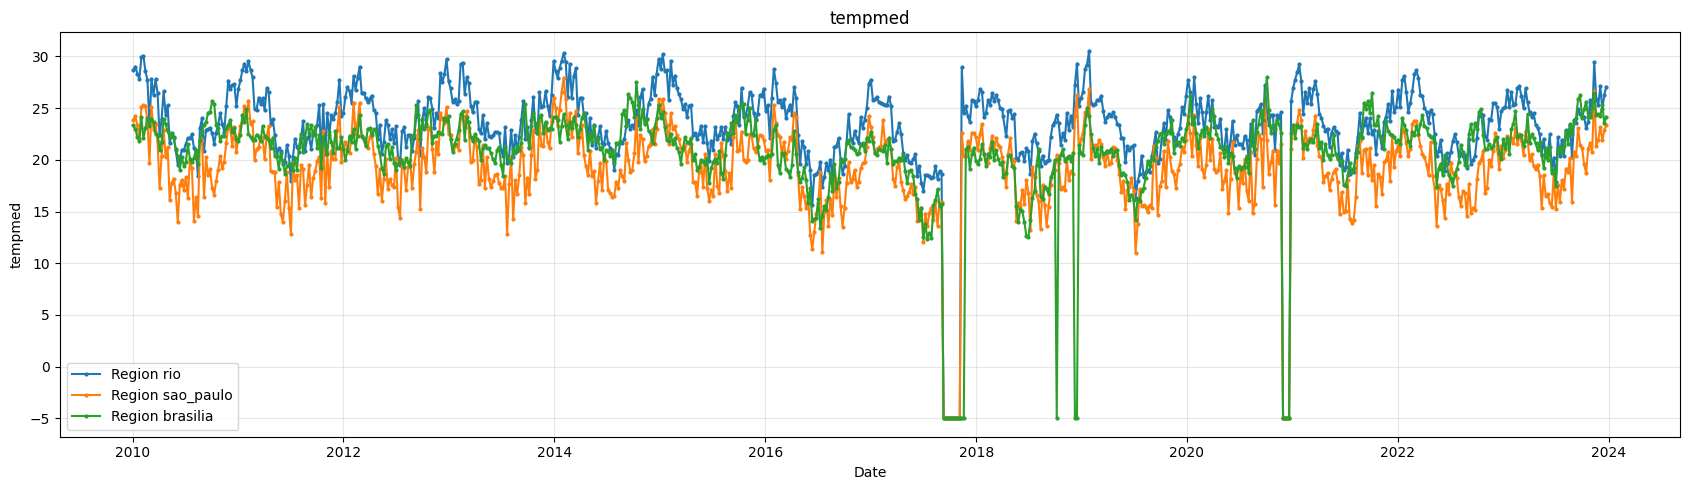

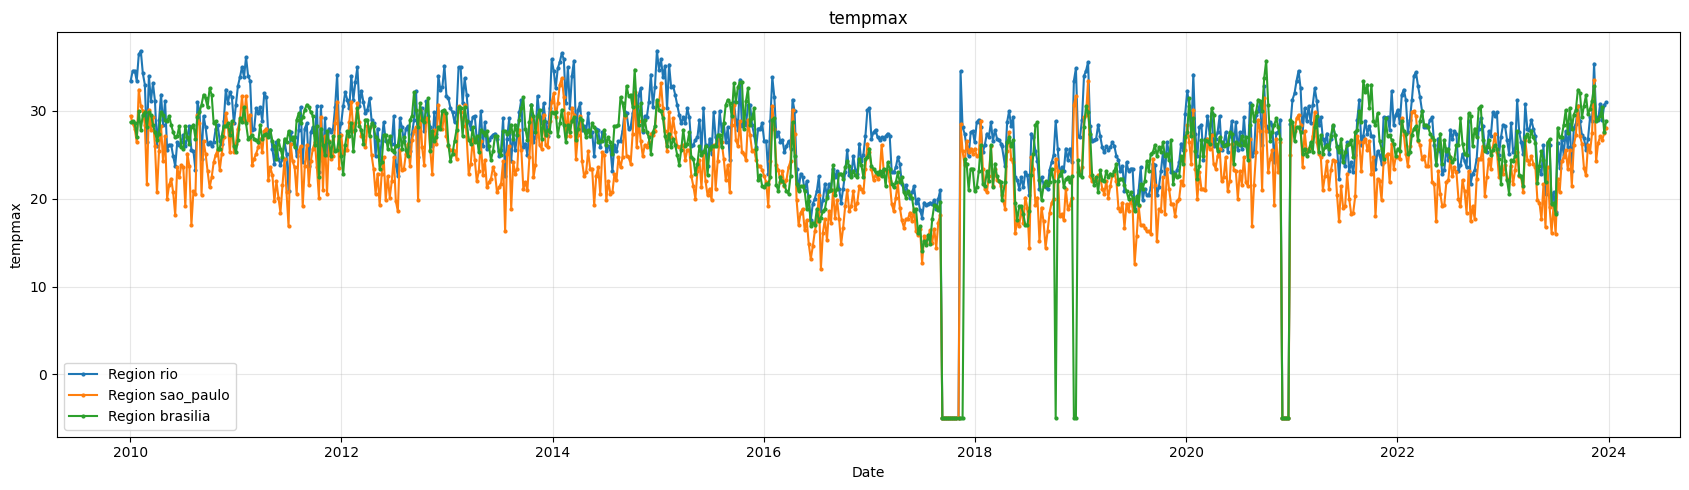

In [15]:
vars_to_plot = ['p_inc100k','tweet','Rt','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax']
plot_ts(all_filt, vars_to_plot, date_col="data_iniSE", region_col="region", na_fill=-5)

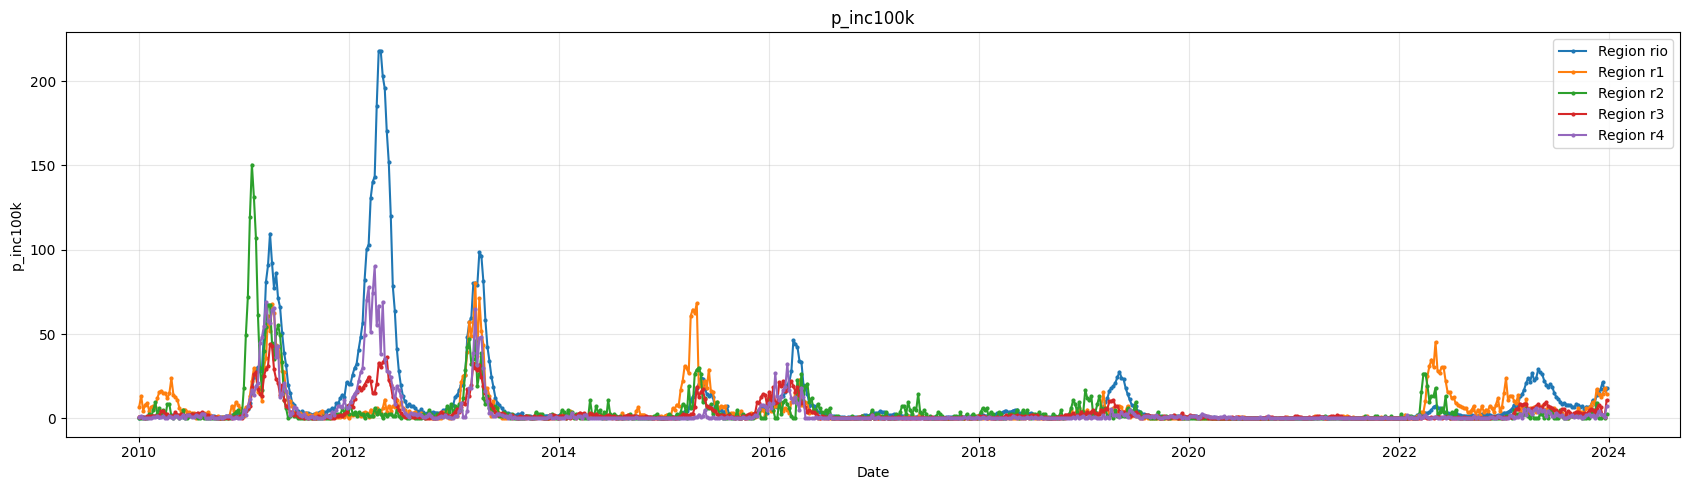

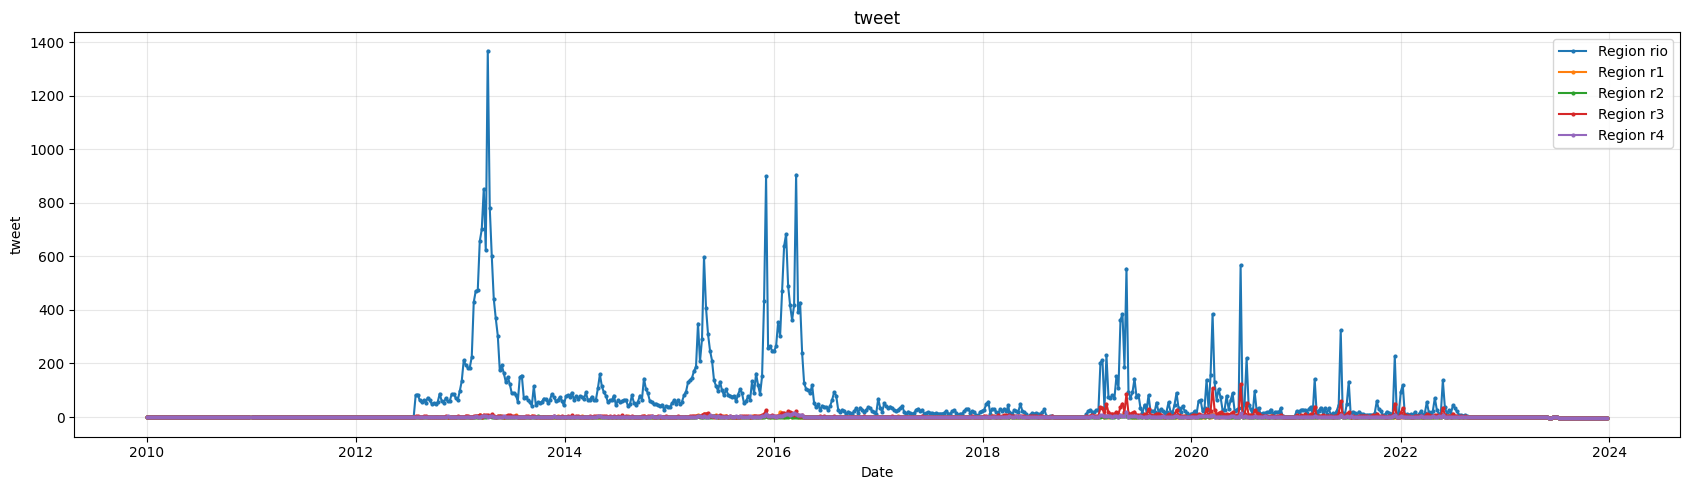

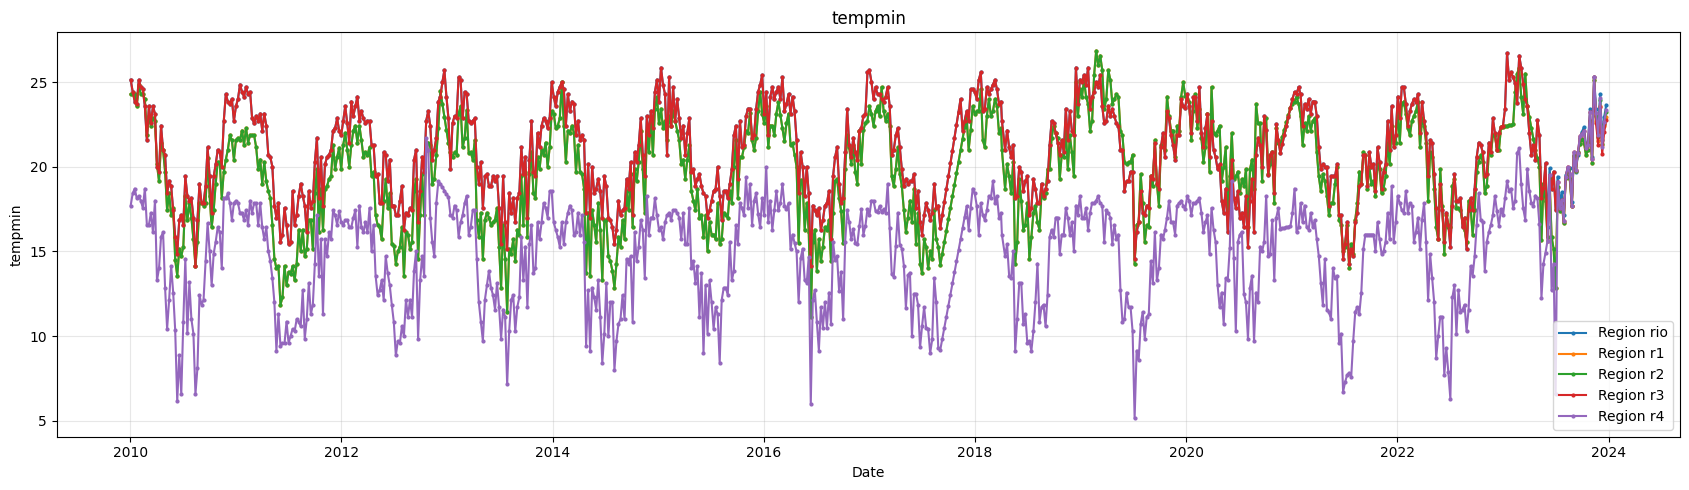

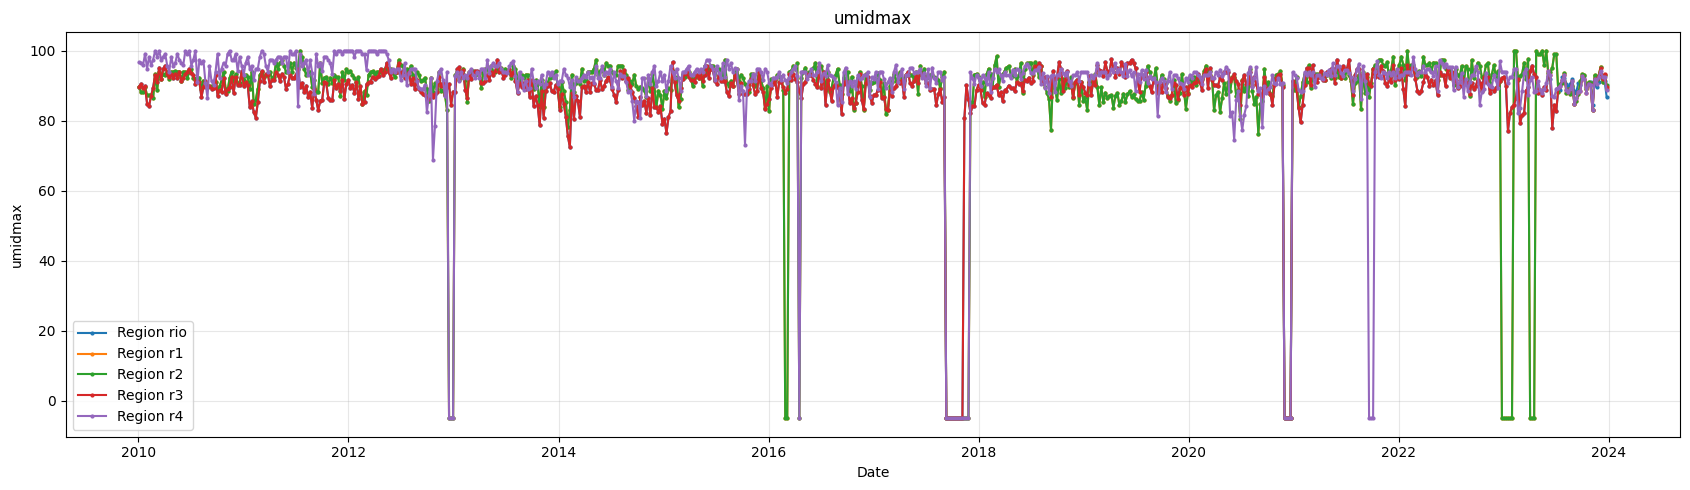

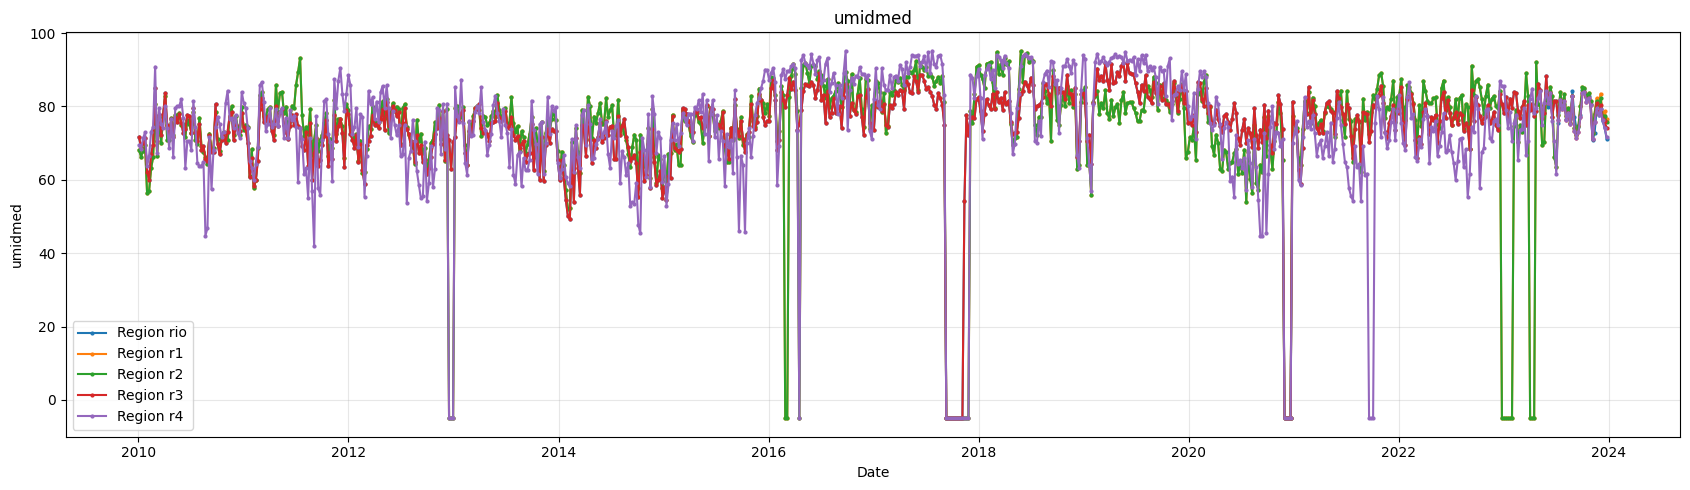

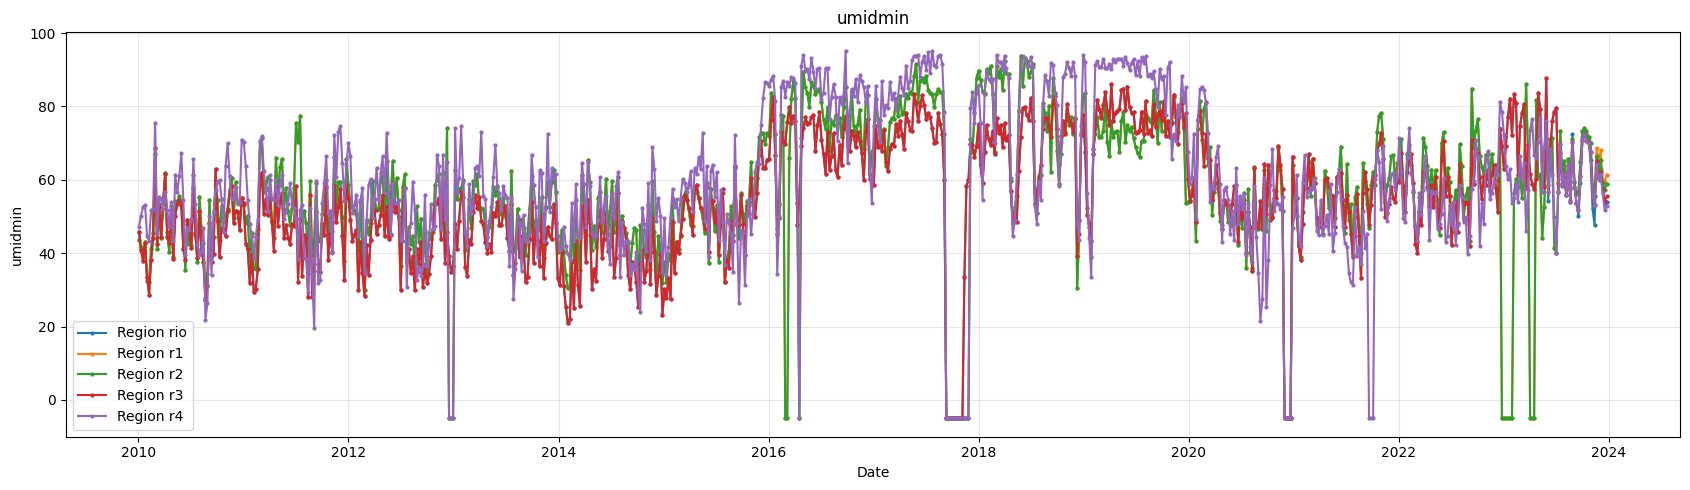

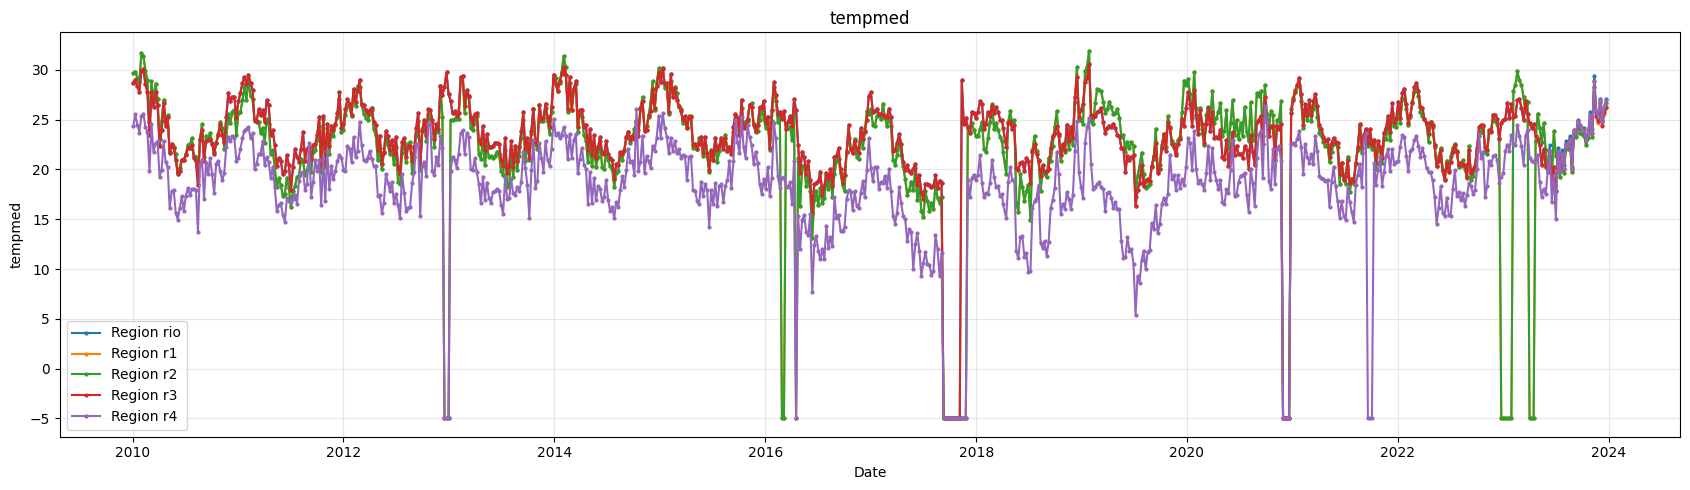

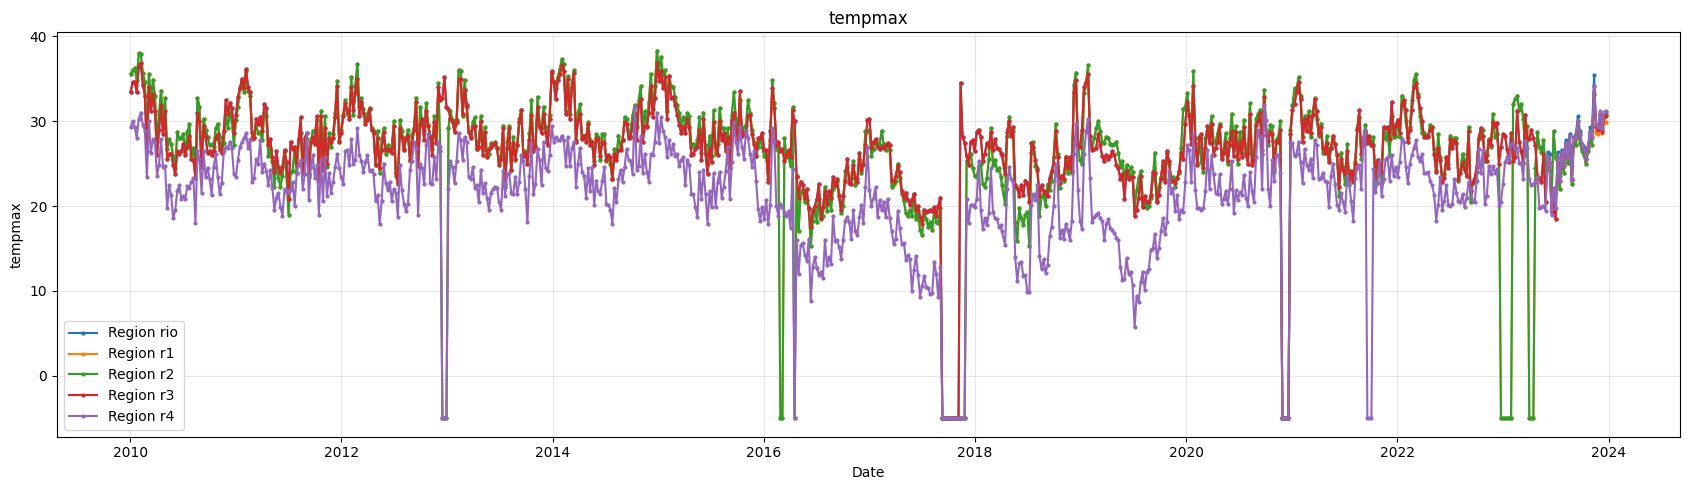

In [16]:
vars_to_plot = ['p_inc100k','tweet','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax']
plot_ts(all2_filt, vars_to_plot, date_col="data_iniSE", region_col="region", na_fill=-5)

In [17]:
## From the graph above, tweet data seems to exists for only the rio, therefore I will not include tweets
all_filt2 = all_filt.copy()
all_filt2.drop(columns=['tweet'], inplace=True)
all_filt2.head(5)

data_iniSE  nivel  p_inc100k        Rt     p_rt1    tempmin  \
SE                                                                    
202352  2023-12-24      4  18.080702  0.975227  0.268316  23.651914   
202351  2023-12-17      4  16.571460  0.956345  0.145074  22.956300   
202350  2023-12-10      4  21.295383  1.413742  1.000000  21.610971   
202349  2023-12-03      4  17.341173  1.371858  1.000000  24.311229   
202348  2023-11-26      4  14.835835  1.410296  1.000000  22.226771   

          umidmax    umidmed    umidmin    tempmed    tempmax region  
SE                                                                    
202352  86.890186  71.218143  53.996714  27.067986  30.961400    rio  
202351  91.337700  74.320886  53.591186  26.296557  30.698757    rio  
202350  90.929043  76.118543  57.914057  24.894814  28.931171    rio  
202349  93.248829  79.297714  62.861486  27.107300  30.804943    rio  
202348  91.169114  77.606257  61.887029  25.268314  28.938500    rio

In [18]:
justrio = all2_filt.copy()
justrio.drop(columns=['tweet'], inplace=True)
justrio.head(5)

data_iniSE  nivel  p_inc100k        Rt     p_rt1    tempmin  \
SE                                                                    
202352  2023-12-24      4  18.080702  0.975227  0.268316  23.651914   
202351  2023-12-17      4  16.571460  0.956345  0.145074  22.956300   
202350  2023-12-10      4  21.295383  1.413742  1.000000  21.610971   
202349  2023-12-03      4  17.341173  1.371858  1.000000  24.311229   
202348  2023-11-26      4  14.835835  1.410296  1.000000  22.226771   

          umidmax    umidmed    umidmin    tempmed    tempmax region  
SE                                                                    
202352  86.890186  71.218143  53.996714  27.067986  30.961400    rio  
202351  91.337700  74.320886  53.591186  26.296557  30.698757    rio  
202350  90.929043  76.118543  57.914057  24.894814  28.931171    rio  
202349  93.248829  79.297714  62.861486  27.107300  30.804943    rio  
202348  91.169114  77.606257  61.887029  25.268314  28.938500    rio

## Data Preparation For LSTM

In [19]:
def prep(df):

  df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
  df = df.sort_values(['region','data_iniSE'])
  pwide = df.pivot_table(index='data_iniSE', columns='region', values='p_inc100k')
  pwide = pwide.add_prefix('pinc_')
  df = df.merge(pwide, left_on='data_iniSE', right_index=True, how='left')
  return df

df = prep(all_filt2)
df_justrio = prep(justrio)

In [20]:
def make_window(df_region, features, target, T=12, horizon=0, mask_val=-5.0):

    g = df_region.sort_values('data_iniSE').copy()

    # Scale
    X_raw = g[features].to_numpy(float)
    mu = np.nanmean(X_raw, axis=0)
    sigma = np.nanstd(X_raw, axis=0); sigma[sigma == 0] = 1.0
    X_scaled = (X_raw - mu) / sigma

    # Mask the NaN
    X_scaled[np.isnan(X_scaled)] = mask_val

    y = g[target].to_numpy()
    dates = g['data_iniSE'].to_numpy()

    # Make the sliding window
    X_seq, y_seq, d_seq = [], [], []
    for i in range(T - 1, len(g) - horizon):
        win = X_scaled[i - T + 1:i + 1]
        y_t = y[i + horizon]
        if np.isnan(y_t) or np.all(win == mask_val):
            continue
        X_seq.append(win)
        y_seq.append(int(y_t))
        d_seq.append(dates[i + horizon])

    return np.array(X_seq), np.array(y_seq), np.array(d_seq), (mu, sigma)


In [21]:
def build_lstm(input_shape, n_classes, mask_val=-5.0):
    model = Sequential([
        Masking(mask_value=mask_val, input_shape=input_shape),
        LSTM(64),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
df_justrio['region']

SE
201001     r1
201002     r1
201003     r1
201004     r1
201005     r1
         ... 
202348    rio
202349    rio
202350    rio
202351    rio
202352    rio
Name: region, Length: 3650, dtype: object

In [23]:
def run_lstm(df):
    local = ['Rt','p_rt1','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax','p_inc100k']
    regions = df['region'].unique()
    pinc_cols = [c for c in df if c.startswith('pinc_')]

    models, results = {}, {}

    for r in regions:
        feats = local + [c for c in pinc_cols if c != f"pinc_{r}"]
        dfr = df[df['region'] == r].sort_values('data_iniSE').copy()

        # encode target
        le = LabelEncoder()
        dfr['nivel_enc'] = le.fit_transform(dfr['nivel'].astype(int))

        # time split
        n = len(dfr)
        train_end = int(n * 0.7)
        val_end   = int(n * 0.85)
        df_train, df_val, df_test = dfr.iloc[:train_end], dfr.iloc[train_end:val_end], dfr.iloc[val_end:]

        # windows
        Xtr, ytr, _, _ = make_window(df_train, feats, 'nivel_enc', T=24, horizon=1, mask_val=-5.0)
        Xva, yva, _, _ = make_window(df_val,   feats, 'nivel_enc', T=24, horizon=1, mask_val=-5.0)
        Xte, yte, dte, _ = make_window(df_test, feats, 'nivel_enc', T=24, horizon=1, mask_val=-5.0)

        if len(Xtr) == 0 or len(Xva) == 0 or len(Xte) == 0:
            print(f"[{r}] skipped: not enough sequence data after split.")
            continue

        n_classes = ytr.max() + 1

        # class weights: I want to make so that 1,2,3 has bigger weight than the 4 (Later improved to also include the weight based on time)
        classes = np.unique(ytr)
        base_weights = compute_class_weight('balanced', classes=classes, y=ytr)
        cw = {int(c): float(w) for c, w in zip(classes, base_weights)}

        # 1.5 for [1,2,3] and 0.8 for [4]
        for c in list(cw.keys()):
            original_label = le.inverse_transform([c])[0]
            if original_label in [1, 2, 3]:
                cw[c] *= 1.5
            elif original_label == 4:
                cw[c] *= 0.8
        print("Class weights used:", cw)



        # model
        model = build_lstm((Xtr.shape[1], Xtr.shape[2]), n_classes, mask_val=-5.0)
        es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
        hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                  epochs=60, batch_size=64, verbose=1, class_weight=cw) #, callbacks=[es])

        models[r] = (model, le)

        # test eval
        probs = model.predict(Xte, verbose=0)
        y_pred_enc = probs.argmax(axis=1)

        acc       = accuracy_score(yte, y_pred_enc)
        precision = precision_score(yte, y_pred_enc, average='weighted', zero_division=0)
        recall    = recall_score(yte, y_pred_enc, average='weighted', zero_division=0)
        f1        = f1_score(yte, y_pred_enc, average='weighted')

        y_true = le.inverse_transform(yte)
        y_pred = le.inverse_transform(y_pred_enc)

        # lead hits (1-week early)
        alarm_classes  = [1, 2, 3]
        outbreak_class = 4
        lead_hits, possible_hits = 0, 0
        for i in range(len(y_true) - 1):
            if y_true[i+1] == outbreak_class:
                possible_hits += 1
                if y_pred[i] in alarm_classes:
                    lead_hits += 1
        lead_rate = lead_hits / possible_hits if possible_hits > 0 else 0

        print(f"Test Accuracy: {acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Weighted F1: {f1:.3f}")
        print(f"Lead Hit Rate (alarm before outbreak): {lead_rate:.3f} ({lead_hits}/{possible_hits})")

        results[r] = {
            "accuracy": acc, "precision": precision, "recall": recall, "f1": f1,
            "lead_rate": lead_rate, "lead_hits": lead_hits, "possible_hits": possible_hits,
            "dates": dte, "y_true": y_true, "y_pred": y_pred, "history": hist.history
        }

    return models, results


In [24]:
models_rr, results_rr = run_lstm(df_justrio)

Class weights used: {0: 0.4872994652406417, 1: 3.1422413793103443, 2: 22.78125, 3: 2.11304347826087}
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3532 - loss: 1.8898 - val_accuracy: 0.3837 - val_loss: 1.3078
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5404 - loss: 1.5421 - val_accuracy: 0.3605 - val_loss: 1.2622
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6230 - loss: 1.4730 - val_accuracy: 0.3605 - val_loss: 1.2445
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6810 - loss: 1.3130 - val_accuracy: 0.3605 - val_loss: 1.2267
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6789 - loss: 1.0752 - val_accuracy: 0.3605 - val_loss: 1.1839
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6960 - loss: 0.9266 - val_accuracy: 0.3953 - val_loss: 1.1026
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7448 - loss: 0.9458 - val_accuracy: 0.4186 - val_loss: 1.0395
Epoch 8/60
8/8 ━━━━━━━━━

Test Accuracy: 0.640 | Precision: 0.796 | Recall: 0.640 | Weighted F1: 0.652
Lead Hit Rate (alarm before outbreak): 0.692 (18/26)
Class weights used: {0: 0.5460674157303371, 2: 20.25, 3: 4.468965517241379}
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2248 - loss: 1.8893 - val_accuracy: 0.3023 - val_loss: 1.3304
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3587 - loss: 1.5342 - val_accuracy: 0.4884 - val_loss: 1.2117
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5163 - loss: 1.1560 - val_accuracy: 0.5116 - val_loss: 1.0732
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6171 - loss: 0.9915 - val_accuracy: 0.6279 - val_loss: 0.9363
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6718 - loss: 0.8194 - val_accuracy: 0.7093 - val_loss: 0.7403
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7355 - loss: 0.6726 - val_accuracy: 0.7907 - val_loss: 0.5853
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

## PLot

In [25]:
def plot_results(region, results):

    y_true = results[region]["y_true"]
    y_pred = results[region]["y_pred"]
    dates  = results[region]["dates"]
    print(len(y_true))

    acc       = results[region].get("accuracy", None)
    precision = results[region].get("precision", None)
    recall    = results[region].get("recall", None)
    f1        = results[region].get("f1", None)
    lead_rate = results[region].get("lead_rate", None)
    lead_hits = results[region].get("lead_hits", None)
    possible_hits = results[region].get("possible_hits", None)

    print(f"\nRegion: {region}")
    print(f"Test Accuracy: {acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Weighted F1: {f1:.3f}")
    print(f"Lead Hit Rate (alarm before outbreak): {lead_rate:.3f} ({lead_hits}/{possible_hits})")

    # Plot the time series
    plt.figure(figsize=(14, 4))
    plt.plot(dates, y_true, label="Actual", marker='o', markersize=3)
    plt.plot(dates, y_pred, label="Predicted", marker='x', markersize=3)
    plt.title(f"Region: {region} — Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Nivel")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # CM
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(f"Region: {region} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


86

Region: r1
Test Accuracy: 0.756 | Precision: 0.749 | Recall: 0.756 | Weighted F1: 0.741
Lead Hit Rate (alarm before outbreak): 0.385 (5/13)


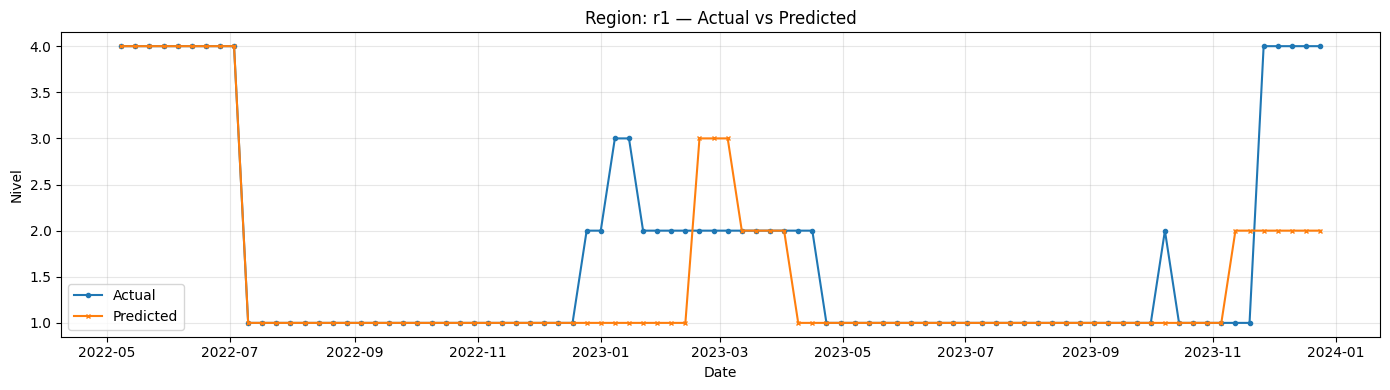

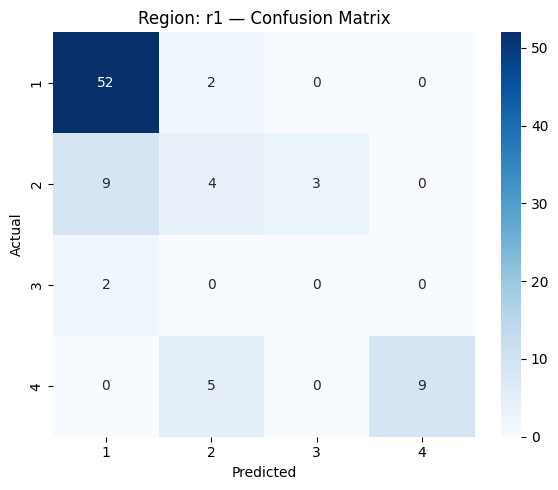

In [26]:
plot_results('r1', results_rr)

In [27]:
def plot(data):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  # Accuracy
  axes[0].plot(data['accuracy'], label='Train Acc')
  axes[0].plot(data['val_accuracy'], label='Val Acc')
  axes[0].set_title("Accuracy over Epochs")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Accuracy")
  axes[0].legend()
  axes[0].grid(True, alpha=0.3)

  # Loss
  axes[1].plot(data['loss'], label='Train Loss')
  axes[1].plot(data['val_loss'], label='Val Loss')
  axes[1].set_title("Loss over Epochs")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Loss")
  axes[1].legend()
  axes[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

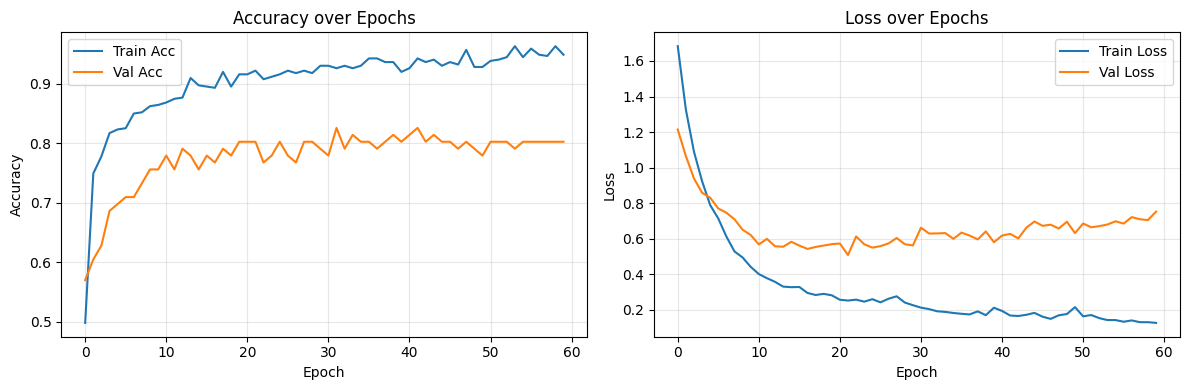

In [28]:
plot(results_rr['rio']['history'])

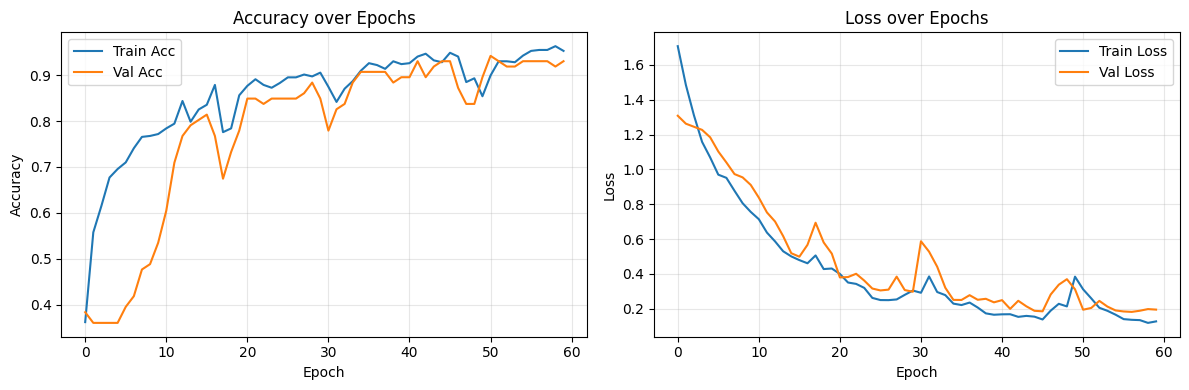

In [29]:
plot(results_rr['r1']['history'])